In [1]:
import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec')
from SANDBOX.nidar import *

Processing...
Done!


Epoch 0, Loss: 1.1108708381652832
Epoch 1, Loss: 1.1183029413223267
Epoch 2, Loss: 1.120874285697937
Epoch 3, Loss: 1.098824143409729
Epoch 4, Loss: 1.1101146936416626
Epoch 5, Loss: 1.1080946922302246
Epoch 6, Loss: 1.1047871112823486
Epoch 7, Loss: 1.1075773239135742
Epoch 8, Loss: 1.1167339086532593
Epoch 9, Loss: 1.1051751375198364
Epoch 10, Loss: 1.1154237985610962
Epoch 11, Loss: 1.103674292564392
Epoch 12, Loss: 1.0892847776412964
Epoch 13, Loss: 1.1070753335952759
Epoch 14, Loss: 1.1078680753707886
Epoch 15, Loss: 1.103735327720642
Epoch 16, Loss: 1.1009520292282104
Epoch 17, Loss: 1.0986133813858032
Epoch 18, Loss: 1.0988672971725464
Epoch 19, Loss: 1.1018568277359009
Epoch 20, Loss: 1.0984455347061157
Epoch 21, Loss: 1.1033680438995361
Epoch 22, Loss: 1.1031982898712158
Epoch 23, Loss: 1.09979248046875
Epoch 24, Loss: 1.1019504070281982
Epoch 25, Loss: 1.102055549621582
Epoch 26, Loss: 1.1060900688171387
Epoch 27, Loss: 1.1060609817504883
Epoch 28, Loss: 1.1041057109832764
Ep

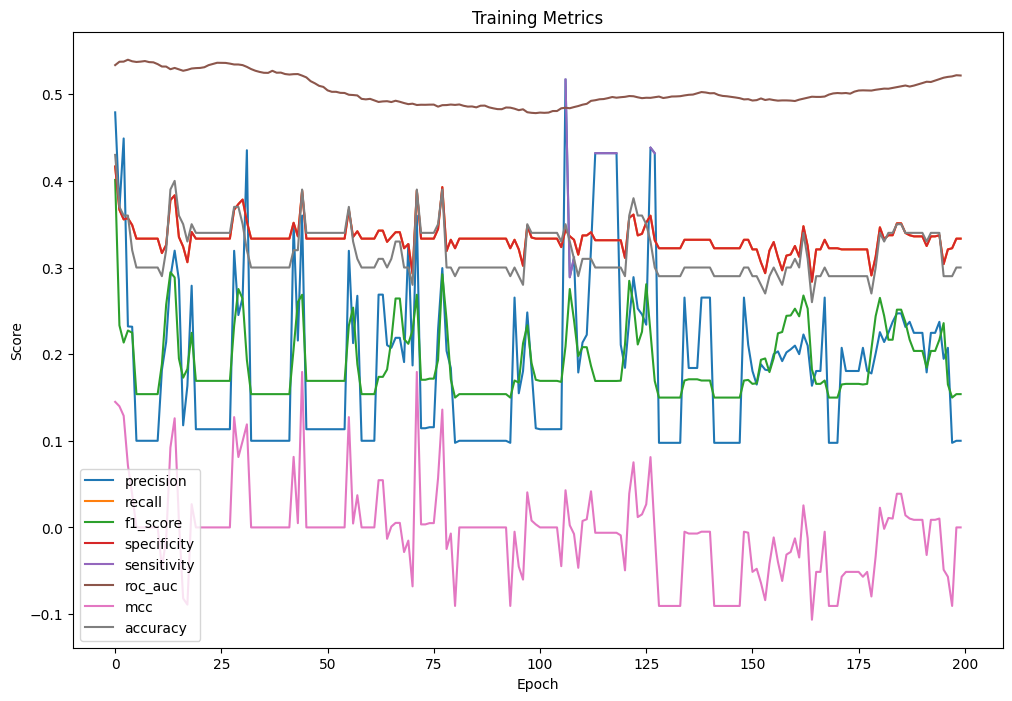

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Create a custom synthetic dataset with 500 nodes
class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__(None, transform)
        self.data, self.slices = self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    def download(self):
        pass

    def process(self):
        num_nodes = 500
        num_node_features = 16
        num_classes = 3

        x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
        edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
        y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:int(0.8 * num_nodes)] = True
        test_mask = ~train_mask

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data = self.transform(data) if self.transform else data

        return data, None

# Save dataset to JSON file
def save_dataset_to_json(data, filename):
    data_dict = {
        'x': data.x.tolist(),
        'edge_index': data.edge_index.tolist(),
        'y': data.y.tolist(),
        'train_mask': data.train_mask.tolist(),
        'test_mask': data.test_mask.tolist()
    }
    with open(filename, 'w') as f:
        json.dump(data_dict, f)

# Load dataset from JSON file
def load_dataset_from_json(filename):
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    data = Data(
        x=torch.tensor(data_dict['x'], dtype=torch.float),
        edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
        y=torch.tensor(data_dict['y'], dtype=torch.long),
        train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
        test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
    )
    return data

# Create and save the dataset
dataset = CustomDataset(transform=NormalizeFeatures())
data = dataset[0]
save_dataset_to_json(data, 'benchmark.json')

# Load the dataset
data = load_dataset_from_json('synthetic_dataset.json')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(in_channels=data.num_node_features, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics = {
    'precision': [],
    'recall': [],
    'f1_score': [],
    'specificity': [],
    'sensitivity': [],
    'roc_auc': [],
    'mcc': [],
    'accuracy': []
}

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()
        
        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        
        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))
        
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)
        metrics['specificity'].append(specificity)
        metrics['sensitivity'].append(sensitivity)
        metrics['roc_auc'].append(roc_auc)
        metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)

for epoch in range(200):
    loss = train()
    evaluate()
    print(f'Epoch {epoch}, Loss: {loss}')

# Plotting the metrics
plt.figure(figsize=(12, 8))
for metric, values in metrics.items():
    plt.plot(values, label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Training Metrics')
plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()

AttributeError: _ARRAY_API not found

Processing...
Done!


GAT Epoch 0, Loss: 1.1178746223449707, Accuracy: 0.25
GAT Epoch 1, Loss: 1.1184252500534058, Accuracy: 0.24
GAT Epoch 2, Loss: 1.0987409353256226, Accuracy: 0.24
GAT Epoch 3, Loss: 1.1000747680664062, Accuracy: 0.24
GAT Epoch 4, Loss: 1.1160943508148193, Accuracy: 0.24
GAT Epoch 5, Loss: 1.1104416847229004, Accuracy: 0.24
GAT Epoch 6, Loss: 1.10581636428833, Accuracy: 0.24
GAT Epoch 7, Loss: 1.1008683443069458, Accuracy: 0.24
GAT Epoch 8, Loss: 1.1015187501907349, Accuracy: 0.24
GAT Epoch 9, Loss: 1.094835638999939, Accuracy: 0.24
GAT Epoch 10, Loss: 1.107441782951355, Accuracy: 0.25
GAT Epoch 11, Loss: 1.1038001775741577, Accuracy: 0.28
GAT Epoch 12, Loss: 1.102648138999939, Accuracy: 0.37
GAT Epoch 13, Loss: 1.1043988466262817, Accuracy: 0.42
GAT Epoch 14, Loss: 1.093031883239746, Accuracy: 0.38
GAT Epoch 15, Loss: 1.0979770421981812, Accuracy: 0.31
GAT Epoch 16, Loss: 1.0952997207641602, Accuracy: 0.25
GAT Epoch 17, Loss: 1.0923632383346558, Accuracy: 0.24
GAT Epoch 18, Loss: 1.1004

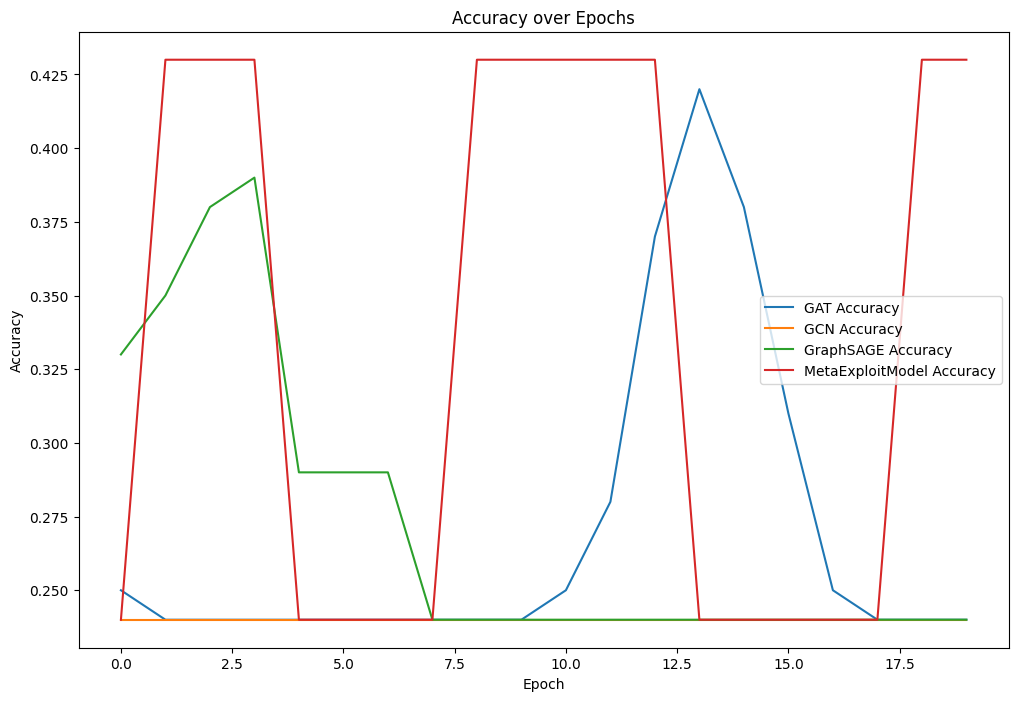


# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
| 1-10 | 0.241 | 0.240 | 0.304 | 0.335 |
| 7-16 | 0.297 | 0.240 | 0.245 | 0.335 |
| 13-22 | 0.245 | 0.192 | 0.192 | 0.249 |
| 19-28 | 0.048 | 0.048 | 0.048 | 0.086 |
| 25-34 | 0.000 | 0.000 | 0.000 | 0.000 |
| 31-40 | 0.000 | 0.000 | 0.000 | 0.000 |
| 37-46 | 0.000 | 0.000 | 0.000 | 0.000 |
| 43-52 | 0.000 | 0.000 | 0.000 | 0.000 |
| 49-58 | 0.000 | 0.000 | 0.000 | 0.000 |
| 55-64 | 0.000 | 0.000 | 0.000 | 0.000 |
| 61-70 | 0.000 | 0.000 | 0.000 | 0.000 |
| 67-76 | 0.000 | 0.000 | 0.000 | 0.000 |
| 73-82 | 0.000 | 0.000 | 0.000 | 0.000 |
| 79-88 | 0.000 | 0.000 | 0.000 | 0.000 |
| 85-94 | 0.000 | 0.000 | 0.000 | 0.000 |
| 91-100 | 0.000 | 0.000 | 0.000 | 0.000 |
| 97-106 | 0.000 | 0.000 | 0.000 | 0.000 |
| 103-112 | 0.000 | 0.000 | 0.000 | 0.000 |
| 109-118 | 0.000 | 0.000 | 0.00

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 

# Create a custom synthetic dataset with 500 nodes
class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__(None, transform)
        self.data, self.slices = self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    def download(self):
        pass

    def process(self):
        num_nodes = 500
        num_node_features = 16
        num_classes = 3

        x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
        edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
        y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:int(0.8 * num_nodes)] = True
        test_mask = ~train_mask

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data = self.transform(data) if self.transform else data

        return data, None

# Save dataset to JSON file
def save_dataset_to_json(data, filename):
    data_dict = {
        'x': data.x.tolist(),
        'edge_index': data.edge_index.tolist(),
        'y': data.y.tolist(),
        'train_mask': data.train_mask.tolist(),
        'test_mask': data.test_mask.tolist()
    }
    with open(filename, 'w') as f:
        json.dump(data_dict, f)

# Load dataset from JSON file
def load_dataset_from_json(filename):
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    data = Data(
        x=torch.tensor(data_dict['x'], dtype=torch.float),
        edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
        y=torch.tensor(data_dict['y'], dtype=torch.long),
        train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
        test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
    )
    return data

# Create and save the dataset
dataset = CustomDataset(transform=NormalizeFeatures())
data = dataset[0]
save_dataset_to_json(data, 'synthetic_dataset.json')

# Load the dataset
data = load_dataset_from_json('synthetic_dataset.json')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
        print(f"adj_matrix shape: {adj_matrix.shape}")
        output = self.model(adj_matrix)
        return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)

# Initialize GAT model
gat_model = GAT(in_channels=data.num_node_features, out_channels=3)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize GCN model
gcn_model = GCN(in_channels=data.num_node_features, out_channels=3)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize GraphSAGE model
graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=3)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize MetaExploitModel
meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.005, weight_decay=5e-4)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Train and evaluate GAT model
for epoch in range(20):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')

# Train and evaluate GCN model
for epoch in range(20):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')

# Train and evaluate GraphSAGE model
for epoch in range(20):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')

# Train and evaluate MetaExploitModel
for epoch in range(20):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='MetaExploitModel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

# Generate benchmark table in markdown
benchmark_table = """
# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
"""

for start_epoch in range(0, 200, 6):
    end_epoch = start_epoch + 10
    gat_acc = sum(gat_metrics['accuracy'][start_epoch:end_epoch]) / 10
    gcn_acc = sum(gcn_metrics['accuracy'][start_epoch:end_epoch]) / 10
    graph_sage_acc = sum(graph_sage_metrics['accuracy'][start_epoch:end_epoch]) / 10
    meta_exploit_acc = sum(meta_exploit_metrics['accuracy'][start_epoch:end_epoch]) / 10
    benchmark_table += f"| {start_epoch + 1}-{end_epoch} | {gat_acc:.3f} | {gcn_acc:.3f} | {graph_sage_acc:.3f} | {meta_exploit_acc:.3f} |\n"

print(benchmark_table)

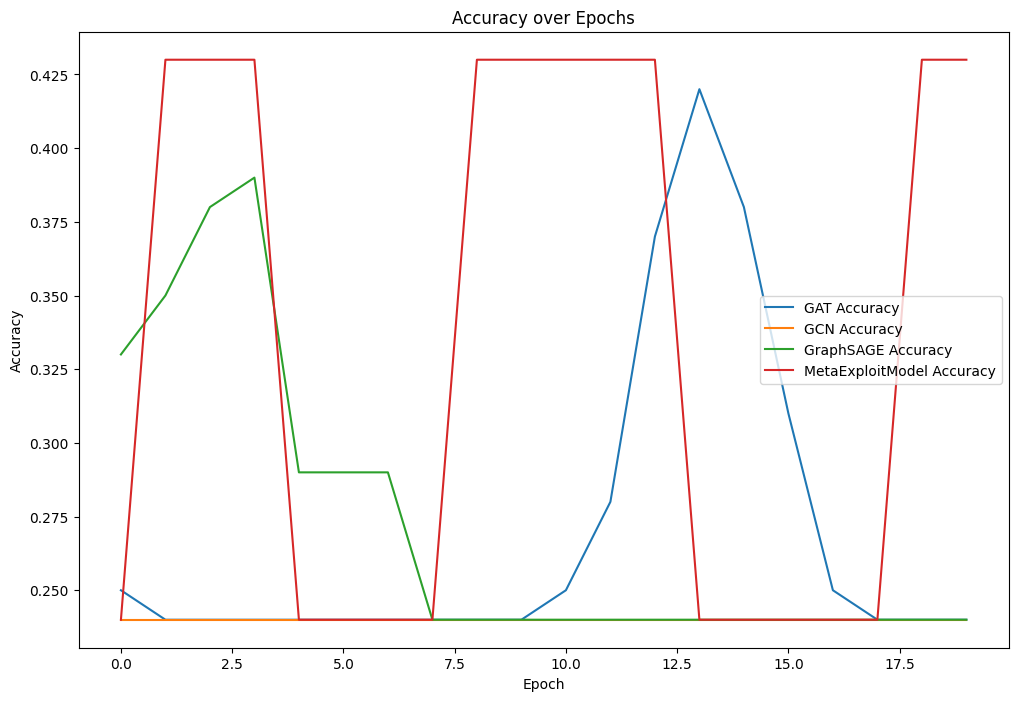

In [4]:
# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='MetaExploitModel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

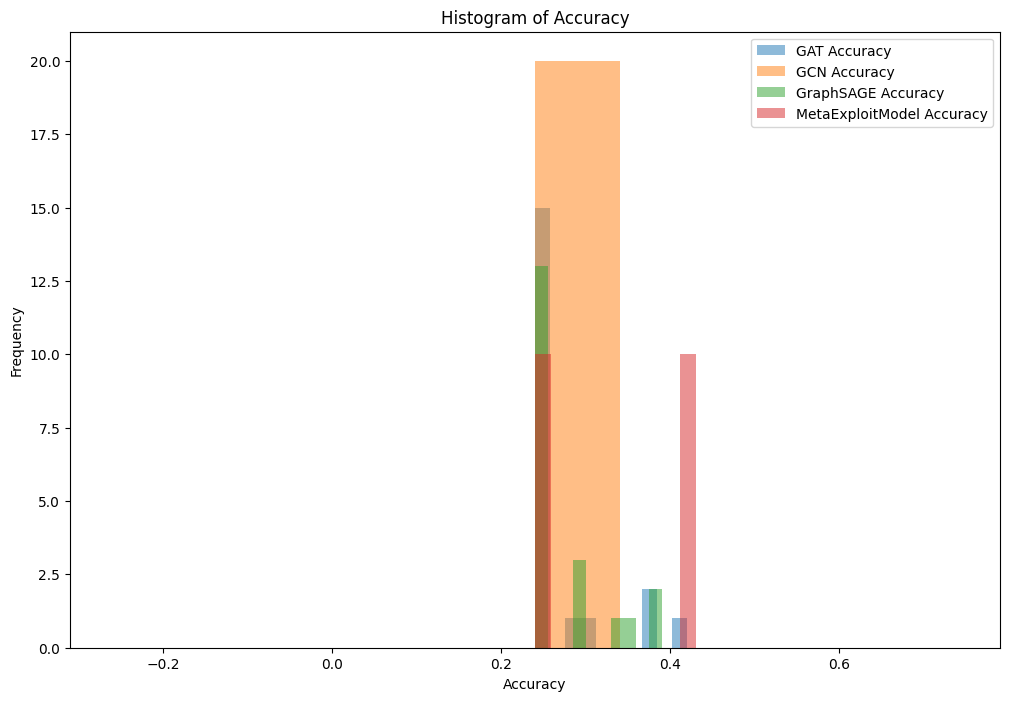

In [5]:
# Histogram of accuracy for each model
plt.figure(figsize=(12, 8))
plt.hist(gat_metrics['accuracy'], bins=10, alpha=0.5, label='GAT Accuracy')
plt.hist(gcn_metrics['accuracy'], bins=10, alpha=0.5, label='GCN Accuracy')
plt.hist(graph_sage_metrics['accuracy'], bins=10, alpha=0.5, label='GraphSAGE Accuracy')
plt.hist(meta_exploit_metrics['accuracy'], bins=10, alpha=0.5, label='MetaExploitModel Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Accuracy')
plt.show()

# working

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# # Import GraphTransformer from core_rec.py
# from core_rec import GraphTransformer 

# # Create a custom synthetic dataset with 500 nodes
# class CustomDataset(InMemoryDataset):
#     def __init__(self, transform=None):
#         super(CustomDataset, self).__init__(None, transform)
#         self.data, self.slices = self.process()

#     @property
#     def raw_file_names(self):
#         return []

#     @property
#     def processed_file_names(self):
#         return []

#     def download(self):
#         pass

#     def process(self):
#         num_nodes = 500
#         num_node_features = 16
#         num_classes = 3

#         x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
#         edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
#         y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

#         train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         train_mask[:int(0.8 * num_nodes)] = True
#         test_mask = ~train_mask

#         data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
#         data = self.transform(data) if self.transform else data

#         return data, None

# # Save dataset to JSON file
# def save_dataset_to_json(data, filename):
#     data_dict = {
#         'x': data.x.tolist(),
#         'edge_index': data.edge_index.tolist(),
#         'y': data.y.tolist(),
#         'train_mask': data.train_mask.tolist(),
#         'test_mask': data.test_mask.tolist()
#     }
#     with open(filename, 'w') as f:
#         json.dump(data_dict, f)

# # Load dataset from JSON file
# def load_dataset_from_json(filename):
#     with open(filename, 'r') as f:
#         data_dict = json.load(f)
#     data = Data(
#         x=torch.tensor(data_dict['x'], dtype=torch.float),
#         edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
#         y=torch.tensor(data_dict['y'], dtype=torch.long),
#         train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
#         test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
#     )
#     return data

# # Create and save the dataset
# dataset = CustomDataset(transform=NormalizeFeatures())
# data = dataset[0]
# save_dataset_to_json(data, 'synthetic_dataset.json')

# # Load the dataset
# data1 = load_dataset_from_json('synthetic_dataset.json')


In [8]:
from torch_geometric.datasets import Planetoid

# Assuming your numpy array is named `data_array`
# data_array = np.loadtxt('data_mother/500label.csv', delimiter=',')
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
# data_array = np.loadtxt('label.csv', delimiter=',')

# Convert numpy array to torch tensor
x = torch.tensor(data.x, dtype=torch.float)
num_nodes = x.size(0)
edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

# Add train_mask and test_mask
num_nodes = x.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask

# Add labels (y) if not already present
num_classes = 3
data.y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

# Now you can access num_node_features
gat_model = GAT(in_channels=data.num_node_features, out_channels=3)

Training Loss: 3.0953915119171143
GAT Epoch 0, Loss: 3.0953915119171143, Accuracy: 0.3154981549815498
Training Loss: 2.6613924503326416
GAT Epoch 1, Loss: 2.6613924503326416, Accuracy: 0.3247232472324723
Training Loss: 2.4391798973083496
GAT Epoch 2, Loss: 2.4391798973083496, Accuracy: 0.3284132841328413
Training Loss: 2.319301128387451
GAT Epoch 3, Loss: 2.319301128387451, Accuracy: 0.3210332103321033
Training Loss: 2.1842539310455322
GAT Epoch 4, Loss: 2.1842539310455322, Accuracy: 0.2915129151291513
Training Loss: 2.1353962421417236
GAT Epoch 5, Loss: 2.1353962421417236, Accuracy: 0.3025830258302583
Training Loss: 2.0525882244110107
GAT Epoch 6, Loss: 2.0525882244110107, Accuracy: 0.3081180811808118
Training Loss: 1.9811878204345703
GAT Epoch 7, Loss: 1.9811878204345703, Accuracy: 0.3081180811808118
Training Loss: 1.907889723777771
GAT Epoch 8, Loss: 1.907889723777771, Accuracy: 0.3044280442804428
Training Loss: 1.8791236877441406
GAT Epoch 9, Loss: 1.8791236877441406, Accuracy: 0.3

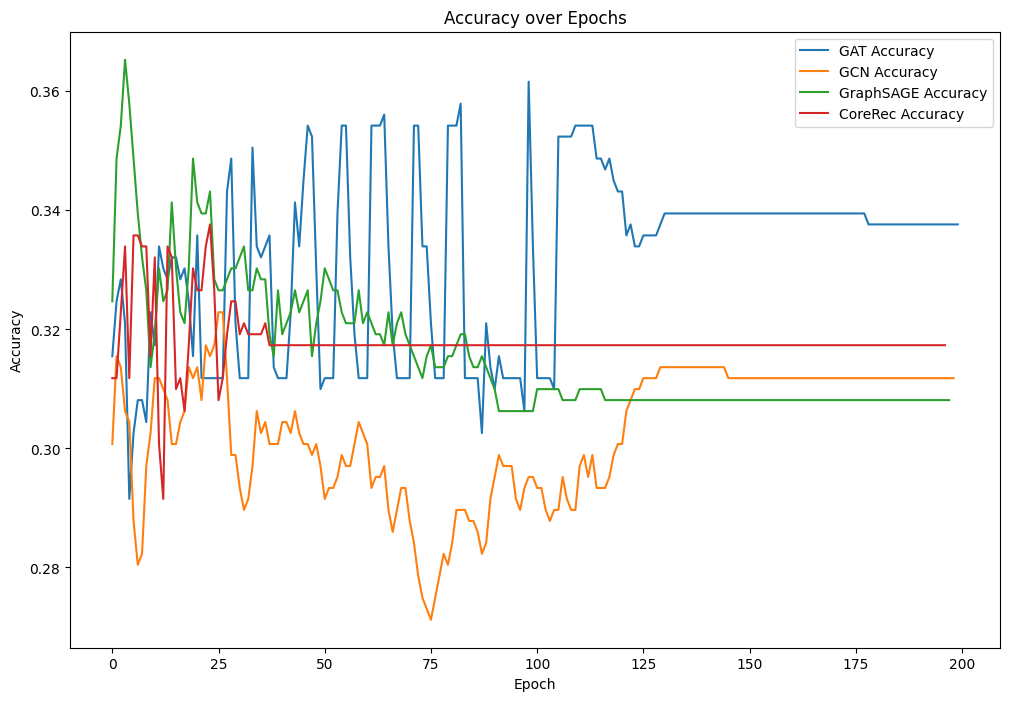

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 8
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.01, weight_decay=5e-4)
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=200
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)


# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

In [10]:

# Generate benchmark table in markdown
benchmark_table = """
# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
"""

for start_epoch in range(0, epoch, 10):
    end_epoch = start_epoch + 10
    gat_acc = sum(gat_metrics['accuracy'][start_epoch:end_epoch]) / 10
    gcn_acc = sum(gcn_metrics['accuracy'][start_epoch:end_epoch]) / 10
    graph_sage_acc = sum(graph_sage_metrics['accuracy'][start_epoch:end_epoch]) / 10
    meta_exploit_acc = sum(meta_exploit_metrics['accuracy'][start_epoch:end_epoch]) / 10
    benchmark_table += f"| {start_epoch + 1}-{end_epoch} | {gat_acc:.3f} | {gcn_acc:.3f} | {graph_sage_acc:.3f} | {meta_exploit_acc:.3f} |\n"

print(benchmark_table)


# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
| 1-10 | 0.000 | 0.100 | 0.700 | 0.367 |
| 11-20 | 0.600 | 0.033 | 0.333 | 0.600 |
| 21-30 | 1.000 | 0.733 | 0.333 | 0.633 |
| 31-40 | 1.000 | 1.000 | 0.333 | 0.667 |
| 41-50 | 1.000 | 1.000 | 0.333 | 0.667 |
| 51-60 | 1.000 | 1.000 | 0.333 | 0.667 |
| 61-70 | 1.000 | 1.000 | 0.333 | 0.667 |
| 71-80 | 1.000 | 1.000 | 0.333 | 0.667 |
| 81-90 | 1.000 | 1.000 | 0.333 | 0.667 |
| 91-100 | 1.000 | 1.000 | 0.333 | 0.667 |
| 101-110 | 1.000 | 1.000 | 0.333 | 0.667 |
| 111-120 | 1.000 | 1.000 | 0.333 | 0.667 |
| 121-130 | 1.000 | 1.000 | 0.333 | 0.667 |
| 131-140 | 1.000 | 1.000 | 0.333 | 0.667 |
| 141-150 | 1.000 | 1.000 | 0.333 | 0.667 |
| 151-160 | 1.000 | 1.000 | 0.333 | 0.667 |
| 161-170 | 1.000 | 1.000 | 0.333 | 0.667 |
| 171-180 | 1.000 | 1.000 | 0.333 | 0.667 |
| 181-190 | 1.000 

Training Loss: 12.20754337310791
GAT Epoch 0, Loss: 12.20754337310791, Accuracy: 0.0
Training Loss: 5.750341415405273
GAT Epoch 1, Loss: 5.750341415405273, Accuracy: 0.0
Training Loss: 5.40600061416626
GAT Epoch 2, Loss: 5.40600061416626, Accuracy: 0.0
Training Loss: 11.775418281555176
GAT Epoch 3, Loss: 11.775418281555176, Accuracy: 0.0
Training Loss: 2.6371712684631348
GAT Epoch 4, Loss: 2.6371712684631348, Accuracy: 0.0
Training Loss: 2.613790512084961
GAT Epoch 5, Loss: 2.613790512084961, Accuracy: 0.0
Training Loss: 3.655461311340332
GAT Epoch 6, Loss: 3.655461311340332, Accuracy: 0.0
Training Loss: 2.2502007484436035
GAT Epoch 7, Loss: 2.2502007484436035, Accuracy: 0.0
Training Loss: 2.9899790287017822
GAT Epoch 8, Loss: 2.9899790287017822, Accuracy: 0.0
Training Loss: 3.9038443565368652
GAT Epoch 9, Loss: 3.9038443565368652, Accuracy: 1.0
Training Loss: 4.0846991539001465
GAT Epoch 10, Loss: 4.0846991539001465, Accuracy: 1.0
Training Loss: 2.6789331436157227
GAT Epoch 11, Loss: 

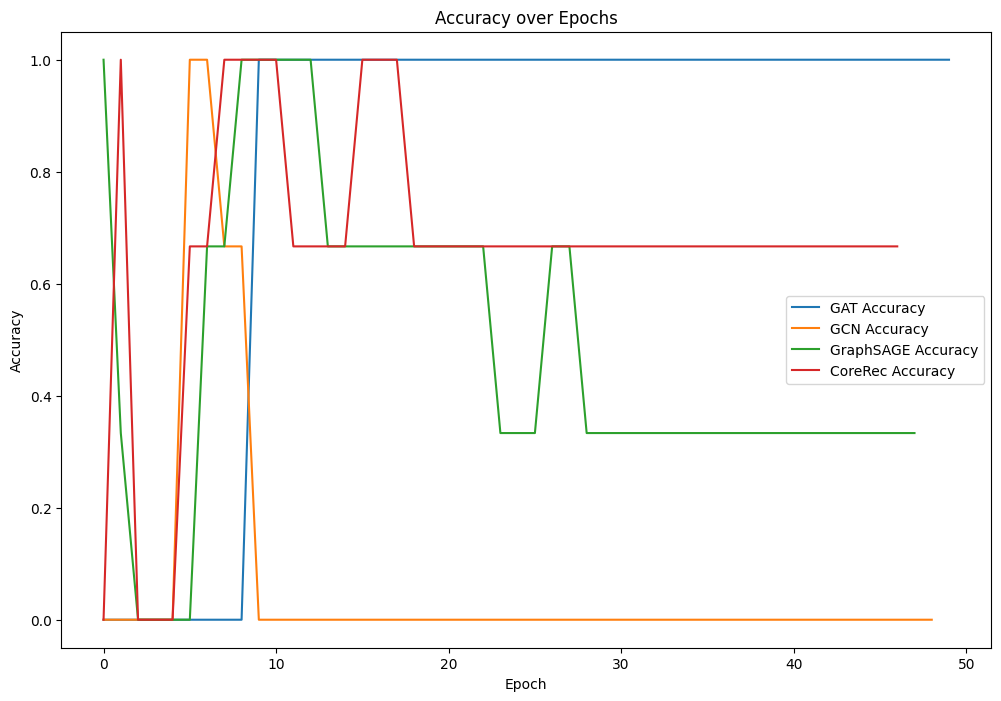

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 8
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.01, weight_decay=5e-4)
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=50
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)


# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

Training Loss: 16.16785430908203
Evaluation Accuracy: 0.0
GAT Epoch 0, Loss: 16.16785430908203, Accuracy: 0.0
Training Loss: 11.058070182800293
Evaluation Accuracy: 0.0
GAT Epoch 1, Loss: 11.058070182800293, Accuracy: 0.0
Training Loss: 4.650393486022949
Evaluation Accuracy: 0.0
GAT Epoch 2, Loss: 4.650393486022949, Accuracy: 0.0
Training Loss: 4.162790775299072
Evaluation Accuracy: 0.0
GAT Epoch 3, Loss: 4.162790775299072, Accuracy: 0.0
Training Loss: 10.440195083618164
Evaluation Accuracy: 0.0
GAT Epoch 4, Loss: 10.440195083618164, Accuracy: 0.0
Training Loss: 15.763487815856934
Evaluation Accuracy: 0.0
GAT Epoch 5, Loss: 15.763487815856934, Accuracy: 0.0
Training Loss: 2.9454727172851562
Evaluation Accuracy: 0.0
GAT Epoch 6, Loss: 2.9454727172851562, Accuracy: 0.0
Training Loss: 2.8745832443237305
Evaluation Accuracy: 0.0
GAT Epoch 7, Loss: 2.8745832443237305, Accuracy: 0.0
Training Loss: 1.549186110496521
Evaluation Accuracy: 0.0
GAT Epoch 8, Loss: 1.549186110496521, Accuracy: 0.0


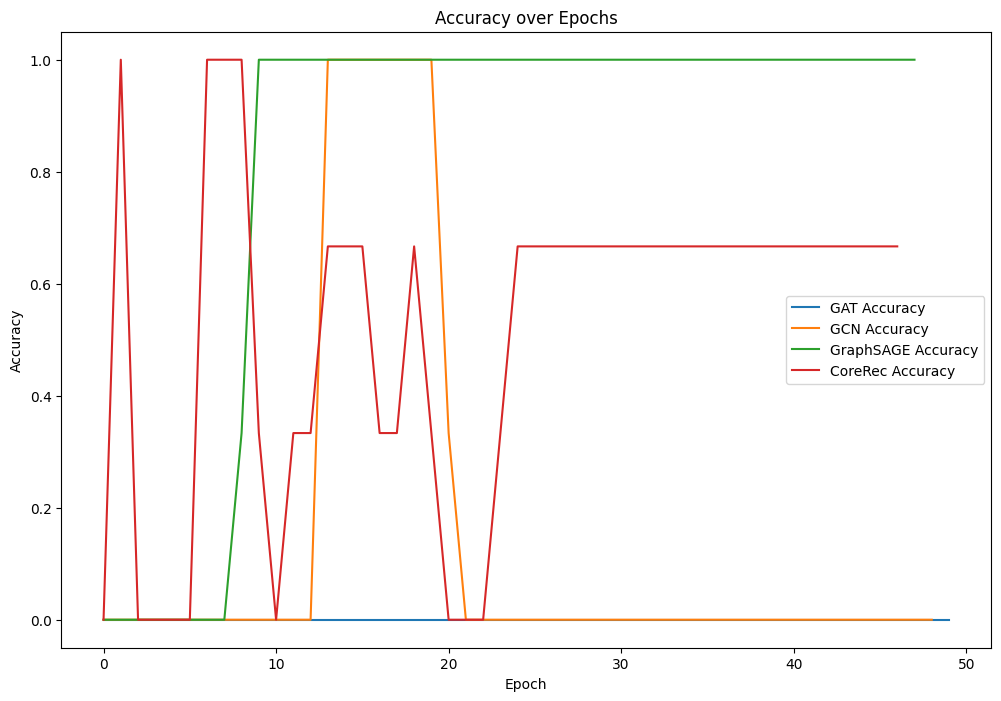

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 4  # Increase the number of layers
        d_model = 256  # Increase the model dimension
        num_heads = 8  # Adjust the number of heads
        d_feedforward = 1024  # Increase the feedforward dimension
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
        print(f"MetaExploitModel output (train): {out[data.train_mask]}")
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
            print(f"MetaExploitModel output (eval): {out[data.test_mask]}")
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        print(f"Evaluation Accuracy: {accuracy}")

        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.001, weight_decay=5e-4)  # Adjusted learning rate
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    'accuracy': []
}

gcn_metrics = {
    'accuracy': []
}

graph_sage_metrics = {
    'accuracy': []
}

meta_exploit_metrics = {
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=50
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

Training Loss: 2.8687665462493896
Evaluation Accuracy: 0.3376383763837638
GAT Epoch 0, Loss: 2.8687665462493896, Accuracy: 0.3376383763837638
Training Loss: 2.5440258979797363
Evaluation Accuracy: 0.3247232472324723
GAT Epoch 1, Loss: 2.5440258979797363, Accuracy: 0.3247232472324723
Training Loss: 2.365507125854492
Evaluation Accuracy: 0.33579335793357934
GAT Epoch 2, Loss: 2.365507125854492, Accuracy: 0.33579335793357934
Training Loss: 2.1901559829711914
Evaluation Accuracy: 0.33579335793357934
GAT Epoch 3, Loss: 2.1901559829711914, Accuracy: 0.33579335793357934
Training Loss: 2.1709558963775635
Evaluation Accuracy: 0.3413284132841328
GAT Epoch 4, Loss: 2.1709558963775635, Accuracy: 0.3413284132841328
Training Loss: 2.089404821395874
Evaluation Accuracy: 0.3247232472324723
GAT Epoch 5, Loss: 2.089404821395874, Accuracy: 0.3247232472324723
Training Loss: 1.9958561658859253
Evaluation Accuracy: 0.3118081180811808
GAT Epoch 6, Loss: 1.9958561658859253, Accuracy: 0.3118081180811808
Traini

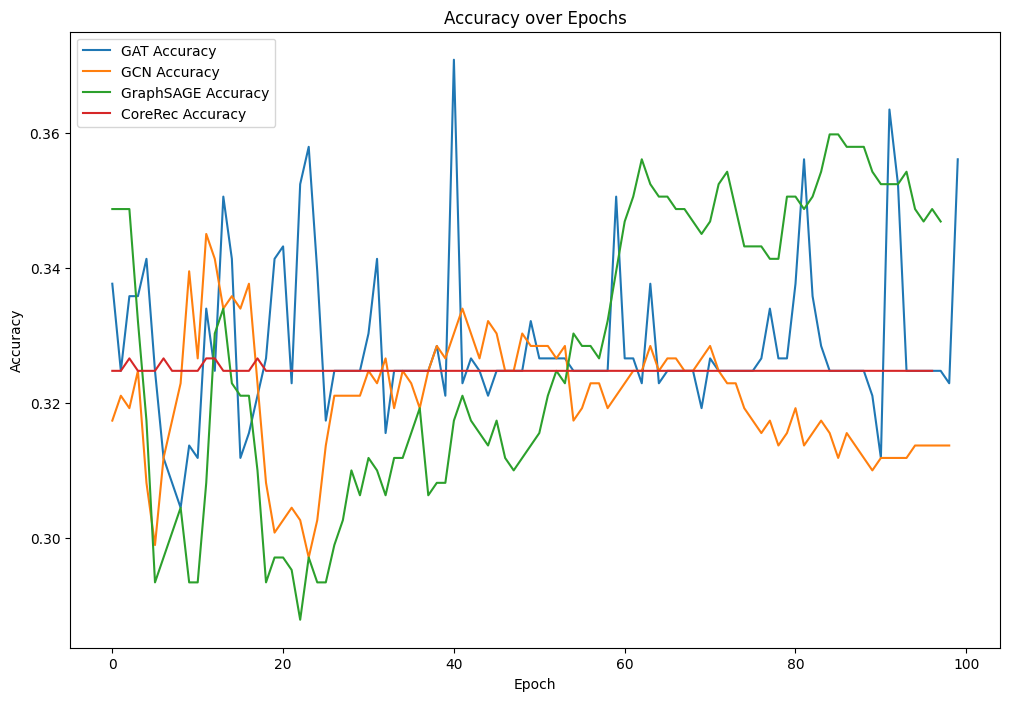

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 2  # Increase the number of layers
        d_model = 128  # Increase the model dimension
        num_heads = 4  # Adjust the number of heads
        d_feedforward = 512  # Increase the feedforward dimension
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
        print(f"MetaExploitModel output (train): {out[data.train_mask]}")
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
            print(f"MetaExploitModel output (eval): {out[data.test_mask]}")
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        print(f"Evaluation Accuracy: {accuracy}")

        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.01, weight_decay=5e-4)  # Adjusted learning rate
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    'accuracy': []
}

gcn_metrics = {
    'accuracy': []
}

graph_sage_metrics = {
    'accuracy': []
}

meta_exploit_metrics = {
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=100
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

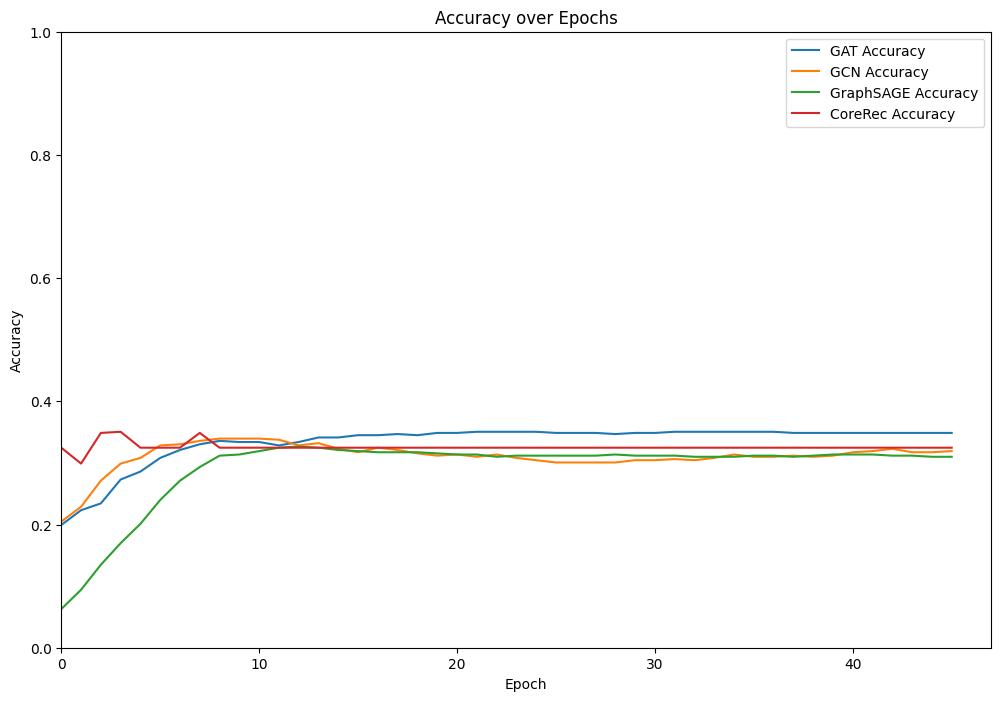

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Ensure all accuracy lists have the same length
min_length = min(len(gat_metrics['accuracy']), len(gcn_metrics['accuracy']), len(graph_sage_metrics['accuracy']), len(meta_exploit_metrics['accuracy']))

gat_metrics['accuracy'] = gat_metrics['accuracy'][:min_length]
gcn_metrics['accuracy'] = gcn_metrics['accuracy'][:min_length]
graph_sage_metrics['accuracy'] = graph_sage_metrics['accuracy'][:min_length]
meta_exploit_metrics['accuracy'] = meta_exploit_metrics['accuracy'][:min_length]

# Function to update the plot
def update(num, gat_metrics, gcn_metrics, graph_sage_metrics, meta_exploit_metrics, line1, line2, line3, line4):
    line1.set_data(range(num), gat_metrics['accuracy'][:num])
    line2.set_data(range(num), gcn_metrics['accuracy'][:num])
    line3.set_data(range(num), graph_sage_metrics['accuracy'][:num])
    line4.set_data(range(num), meta_exploit_metrics['accuracy'][:num])
    return line1, line2, line3, line4

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, min_length)
ax.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy over Epochs')

# Initialize lines
line1, = ax.plot([], [], label='GAT Accuracy')
line2, = ax.plot([], [], label='GCN Accuracy')
line3, = ax.plot([], [], label='GraphSAGE Accuracy')
line4, = ax.plot([], [], label='CoreRec Accuracy')
ax.legend()

# Create animation
ani = animation.FuncAnimation(fig, update, frames=min_length, fargs=(gat_metrics, gcn_metrics, graph_sage_metrics, meta_exploit_metrics, line1, line2, line3, line4), blit=True)

# Save animation
ani.save('accuracy_animation.mp4', writer='ffmpeg')

plt.show()